In [ ]:
#| default_exp models.tsmixer

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# TSMixer
> Time-Series Mixer (`TSMixer`) is a MLP-based multivariate time-series forecasting model. `TSMixer` jointly learns temporal and cross-sectional representations of the time-series by repeatedly combining time- and feature information using stacked mixing layers. A mixing layer consists of a sequential time- and feature Multi Layer Perceptron (`MLP`). Note: this model cannot handle exogenous inputs. If you want to use additional exogenous inputs, use `TSMixerx`.

<br><br>**References**<br>-[Chen, Si-An, Chun-Liang Li, Nate Yoder, Sercan O. Arik, and Tomas Pfister (2023). "TSMixer: An All-MLP Architecture for Time Series Forecasting."](http://arxiv.org/abs/2303.06053)<br>

![Figure 1. TSMixer for multivariate time series forecasting.](imgs_models/tsmixer.png)

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [ ]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import Optional
from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_model import BaseModel

c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Auxiliary Functions

## 1.1 Mixing layers
A mixing layer consists of a sequential time- and feature Multi Layer Perceptron (`MLP`).

In [ ]:
#| exporti
class TemporalMixing(nn.Module):
    def __init__(self, n_series, input_size, dropout):
        super().__init__()
        self.temporal_norm = nn.BatchNorm1d(num_features=n_series * input_size, eps=0.001, momentum=0.01)
        self.temporal_lin = nn.Linear(input_size, input_size)
        self.temporal_drop = nn.Dropout(dropout)

    def forward(self, input):
        # Get shapes
        batch_size = input.shape[0]
        input_size = input.shape[1]
        n_series = input.shape[2]

        # Temporal MLP
        x = input.permute(0, 2, 1)                                      # [B, L, N] -> [B, N, L]
        x = x.reshape(batch_size, -1)                                   # [B, N, L] -> [B, N * L]
        x = self.temporal_norm(x)                                       # [B, N * L] -> [B, N * L]
        x = x.reshape(batch_size, n_series, input_size)                 # [B, N * L] -> [B, N, L]
        x = F.relu(self.temporal_lin(x))                                # [B, N, L] -> [B, N, L]
        x = x.permute(0, 2, 1)                                          # [B, N, L] -> [B, L, N]
        x = self.temporal_drop(x)                                       # [B, L, N] -> [B, L, N]

        return x + input 

class FeatureMixing(nn.Module):
    def __init__(self, n_series, input_size, dropout, ff_dim):
        super().__init__()
        self.feature_norm = nn.BatchNorm1d(num_features=n_series * input_size, eps=0.001, momentum=0.01)
        self.feature_lin_1 = nn.Linear(n_series, ff_dim)
        self.feature_lin_2 = nn.Linear(ff_dim, n_series)
        self.feature_drop_1 = nn.Dropout(dropout)
        self.feature_drop_2 = nn.Dropout(dropout)

    def forward(self, input):
        # Get shapes
        batch_size = input.shape[0]
        input_size = input.shape[1]
        n_series = input.shape[2]

        # Feature MLP
        x = input.reshape(batch_size, -1)                               # [B, L, N] -> [B, L * N]
        x = self.feature_norm(x)                                        # [B, L * N] -> [B, L * N]
        x = x.reshape(batch_size, input_size, n_series)                 # [B, L * N] -> [B, L, N]
        x = F.relu(self.feature_lin_1(x))                               # [B, L, N] -> [B, L, ff_dim]
        x = self.feature_drop_1(x)                                      # [B, L, ff_dim] -> [B, L, ff_dim]
        x = self.feature_lin_2(x)                                       # [B, L, ff_dim] -> [B, L, N]
        x = self.feature_drop_2(x)                                      # [B, L, N] -> [B, L, N]

        return x + input 

class MixingLayer(nn.Module):
    def __init__(self, n_series, input_size, dropout, ff_dim):
        super().__init__()
        # Mixing layer consists of a temporal and feature mixer
        self.temporal_mixer = TemporalMixing(n_series, input_size, dropout)
        self.feature_mixer = FeatureMixing(n_series, input_size, dropout, ff_dim)

    def forward(self, input):
        x = self.temporal_mixer(input)
        x = self.feature_mixer(x)
        return x

## 1.2 Reversible InstanceNormalization
An Instance Normalization Layer that is reversible, based on [this reference implementation](https://github.com/google-research/google-research/blob/master/tsmixer/tsmixer_basic/models/rev_in.py).<br>

In [ ]:
#| exporti
class ReversibleInstanceNorm1d(nn.Module):
    def __init__(self, n_series, eps=1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones((1, 1, n_series)))
        self.bias = nn.Parameter(torch.zeros((1, 1, n_series)))

        self.eps = eps

    def forward(self, x):
        # Batch statistics
        self.batch_mean = torch.mean(x, axis=1, keepdim=True).detach()
        self.batch_std = torch.sqrt(torch.var(x, axis=1, keepdim=True, unbiased=False) + self.eps).detach()
        
        # Instance normalization
        x = x - self.batch_mean
        x = x / self.batch_std
        x = x * self.weight
        x = x + self.bias
        
        return x

    def reverse(self, x):
        # Reverse the normalization
        x = x - self.bias
        x = x / self.weight       
        x = x * self.batch_std
        x = x + self.batch_mean       

        return x

### 2. Model

In [ ]:
#| export
class TSMixer(BaseModel):
    """ TSMixer

    Time-Series Mixer (`TSMixer`) is a MLP-based multivariate time-series forecasting model. `TSMixer` jointly learns temporal and cross-sectional representations of the time-series by repeatedly combining time- and feature information using stacked mixing layers. A mixing layer consists of a sequential time- and feature Multi Layer Perceptron (`MLP`).

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
    `n_series`: int, number of time-series.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `n_block`: int=2, number of mixing layers in the model.<br>
    `ff_dim`: int=64, number of units for the second feed-forward layer in the feature MLP.<br>
    `dropout`: float=0.9, dropout rate between (0, 1) .<br>
    `revin`: bool=True, if True uses Reverse Instance Normalization to process inputs and outputs.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>    
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    **References:**<br>
    - [Chen, Si-An, Chun-Liang Li, Nate Yoder, Sercan O. Arik, and Tomas Pfister (2023). "TSMixer: An All-MLP Architecture for Time Series Forecasting."](http://arxiv.org/abs/2303.06053)

    """
    # Class attributes
    EXOGENOUS_FUTR = False
    EXOGENOUS_HIST = False
    EXOGENOUS_STAT = False
    MULTIVARIATE = True    # If the model produces multivariate forecasts (True) or univariate (False)
    RECURRENT = False       # If the model produces forecasts recursively (True) or direct (False)

    def __init__(self,
                 h,
                 input_size,
                 n_series,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 n_block = 2,
                 ff_dim = 64,
                 dropout = 0.9,
                 revin = True,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 inference_windows_batch_size = 1024,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,
                 **trainer_kwargs):

        # Inherit BaseMultivariate class
        super(TSMixer, self).__init__(h=h,
                                    input_size=input_size,
                                    n_series=n_series,
                                    futr_exog_list=futr_exog_list,
                                    hist_exog_list=hist_exog_list,
                                    stat_exog_list=stat_exog_list,
                                    exclude_insample_y = exclude_insample_y,
                                    loss=loss,
                                    valid_loss=valid_loss,
                                    max_steps=max_steps,
                                    learning_rate=learning_rate,
                                    num_lr_decays=num_lr_decays,
                                    early_stop_patience_steps=early_stop_patience_steps,
                                    val_check_steps=val_check_steps,
                                    batch_size=batch_size,
                                    valid_batch_size=valid_batch_size,
                                    windows_batch_size=windows_batch_size,
                                    inference_windows_batch_size=inference_windows_batch_size,
                                    start_padding_enabled=start_padding_enabled,
                                    step_size=step_size,
                                    scaler_type=scaler_type,
                                    random_seed=random_seed,
                                    num_workers_loader=num_workers_loader,
                                    drop_last_loader=drop_last_loader,
                                    optimizer=optimizer,
                                    optimizer_kwargs=optimizer_kwargs,
                                    lr_scheduler=lr_scheduler,
                                    lr_scheduler_kwargs=lr_scheduler_kwargs,
                                    **trainer_kwargs)

        # Reversible InstanceNormalization layer
        self.revin = revin
        if self.revin:
            self.norm = ReversibleInstanceNorm1d(n_series = n_series)

        # Mixing layers
        mixing_layers = [MixingLayer(n_series=n_series, 
                                     input_size=input_size, 
                                     dropout=dropout, 
                                     ff_dim=ff_dim) 
                                     for _ in range(n_block)]
        self.mixing_layers = nn.Sequential(*mixing_layers)

        # Linear output with Loss dependent dimensions
        self.out = nn.Linear(in_features=input_size, 
                             out_features=h * self.loss.outputsize_multiplier)

    def forward(self, windows_batch):
        # Parse batch
        x = windows_batch['insample_y']  # x: [batch_size, input_size, n_series]
        batch_size = x.shape[0]

        # TSMixer: InstanceNorm + Mixing layers + Dense output layer + ReverseInstanceNorm
        if self.revin:
            x = self.norm(x)
        x = self.mixing_layers(x)
        x = x.permute(0, 2, 1)
        x = self.out(x)
        x = x.permute(0, 2, 1)
        if self.revin:
            x = self.norm.reverse(x)

        x = x.reshape(batch_size, self.h, self.loss.outputsize_multiplier * self.n_series)
        forecast = self.loss.domain_map(x)

        return forecast

In [ ]:
show_doc(TSMixer)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/tsmixer.py#L120){target="_blank" style="float:right; font-size:smaller"}

### TSMixer

>      TSMixer (h, input_size, n_series, futr_exog_list=None,
>               hist_exog_list=None, stat_exog_list=None,
>               exclude_insample_y=False, n_block=2, ff_dim=64, dropout=0.9,
>               revin=True, loss=MAE(), valid_loss=None, max_steps:int=1000,
>               learning_rate:float=0.001, num_lr_decays:int=-1,
>               early_stop_patience_steps:int=-1, val_check_steps:int=100,
>               batch_size:int=32, valid_batch_size:Optional[int]=None,
>               windows_batch_size=1024, inference_windows_batch_size=1024,
>               start_padding_enabled=False, step_size:int=1,
>               scaler_type:str='identity', random_seed:int=1,
>               num_workers_loader:int=0, drop_last_loader:bool=False,
>               optimizer=None, optimizer_kwargs=None, lr_scheduler=None,
>               lr_scheduler_kwargs=None, **trainer_kwargs)

*TSMixer

Time-Series Mixer (`TSMixer`) is a MLP-based multivariate time-series forecasting model. `TSMixer` jointly learns temporal and cross-sectional representations of the time-series by repeatedly combining time- and feature information using stacked mixing layers. A mixing layer consists of a sequential time- and feature Multi Layer Perceptron (`MLP`).

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
`n_series`: int, number of time-series.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`n_block`: int=2, number of mixing layers in the model.<br>
`ff_dim`: int=64, number of units for the second feed-forward layer in the feature MLP.<br>
`dropout`: float=0.9, dropout rate between (0, 1) .<br>
`revin`: bool=True, if True uses Reverse Instance Normalization to process inputs and outputs.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
`lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>    
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

**References:**<br>
- [Chen, Si-An, Chun-Liang Li, Nate Yoder, Sercan O. Arik, and Tomas Pfister (2023). "TSMixer: An All-MLP Architecture for Time Series Forecasting."](http://arxiv.org/abs/2303.06053)*

In [ ]:
show_doc(TSMixer.fit, name='TSMixer.fit')

---

### TSMixer.fit

>      TSMixer.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                   distributed_config=None)

*Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>*

In [ ]:
show_doc(TSMixer.predict, name='TSMixer.predict')

---

### TSMixer.predict

>      TSMixer.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                       **data_module_kwargs)

*Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).*

## 3. Usage Examples

Train model and forecast future values with `predict` method.

In [ ]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.losses.pytorch import MAE

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = TSMixer(h=12,
                input_size=24,
                n_series=2, 
                n_block=4,
                ff_dim=4,
                dropout=0,
                revin=True,
                scaler_type='standard',
                max_steps=200,
                early_stop_patience_steps=-1,
                val_check_steps=5,
                learning_rate=1e-3,
                loss=MAE(),
                valid_loss=MAE(),
                batch_size=32
                )

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                     | Params
-----------------------------------------------------------
0 | loss          | MAE                      | 0     
1 | valid_loss    | MAE                      | 0     
2 | padder_train  | ConstantPad1d            | 0     
3 | scaler        | TemporalNorm             | 0     
4 | norm          | ReversibleInstanceNorm1d | 4     
5 | mixing_layers | Sequential             

Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 33.88it/s, v_num=3937, train_loss_step=0.240, train_loss_epoch=0.240, valid_loss=20.40]  

`Trainer.fit` stopped: `max_steps=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 32.00it/s, v_num=3937, train_loss_step=0.240, train_loss_epoch=0.240, valid_loss=20.40]


c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:374: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:428: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.18it/s]


c:\Users\ospra\OneDrive\Phd\Repositories\neuralforecast\neuralforecast\core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


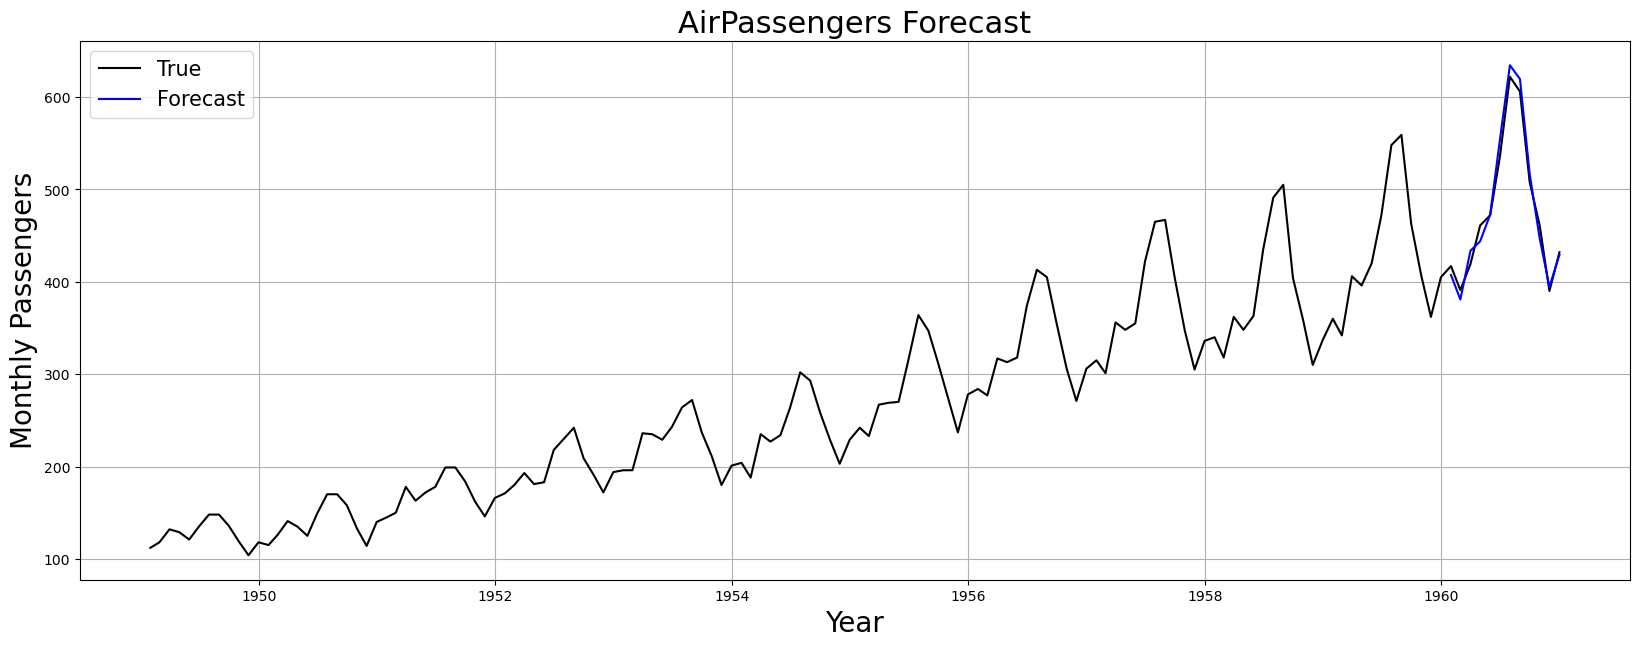

In [ ]:
#| eval: false
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['TSMixer'], c='blue', label='Forecast')
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

Using `cross_validation` to forecast multiple historic values.

In [ ]:
#| eval: false
fcst = NeuralForecast(models=[model], freq='M')
forecasts = fcst.cross_validation(df=AirPassengersPanel, static_df=AirPassengersStatic, n_windows=2, step_size=12)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                     | Params
-----------------------------------------------------------
0 | loss          | MAE                      | 0     
1 | valid_loss    | MAE                      | 0     
2 | padder_train  | ConstantPad1d            | 0     
3 | scaler        | TemporalNorm             | 0     
4 | norm          | ReversibleInstanceNorm1d | 4     
5 | mixing_layers | Sequential               | 3.3 K 
6 | out           | Linear                   | 300   
-----------------------------------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.014     Total estimated model params size (MB)


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 30.17it/s, v_num=3939, train_loss_step=0.240, train_loss_epoch=0.240] 

`Trainer.fit` stopped: `max_steps=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 28.10it/s, v_num=3939, train_loss_step=0.240, train_loss_epoch=0.240]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.26it/s]


c:\Users\ospra\OneDrive\Phd\Repositories\neuralforecast\neuralforecast\core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


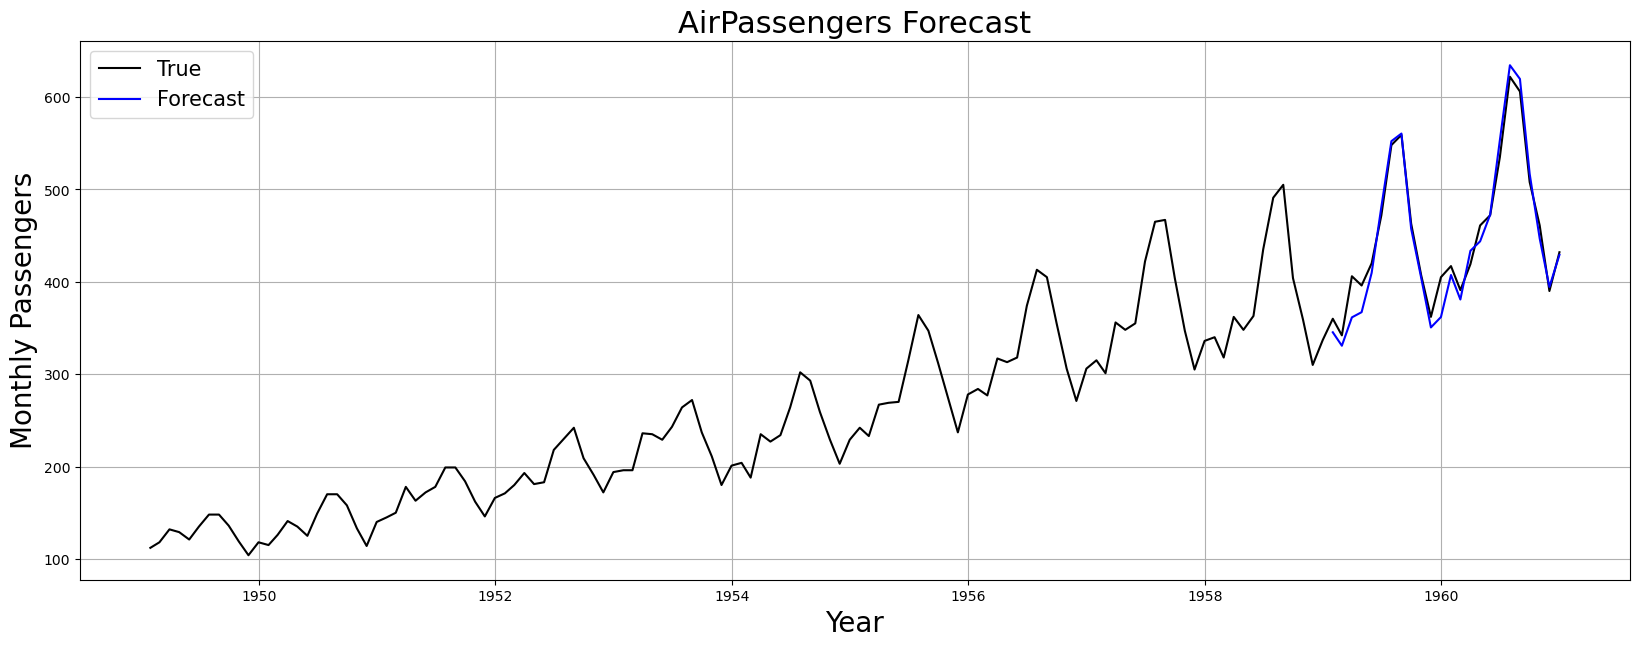

In [ ]:
#| eval: false
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = forecasts.loc['Airline1']
Y_df = AirPassengersPanel[AirPassengersPanel['unique_id']=='Airline1']

plt.plot(Y_df['ds'], Y_df['y'], c='black', label='True')
plt.plot(Y_hat_df['ds'], Y_hat_df['TSMixer'], c='blue', label='Forecast')
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()